In [110]:
!pip install tensorflow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [112]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [113]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [114]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [115]:
def create_time_steps(length):
    return list(range(-length, 0))

In [116]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [117]:
tf.random.set_seed(13)

In [118]:
df = pd.read_csv('../../data/raw/parabola_30K.csv', index_col='x')
df.head()

,fx
x,
-15000,225000000
-14999,224970001
-14998,224940004
-14997,224910009
-14996,224880016


In [119]:
int(df.shape[0] * 0.5)

15000

In [120]:
df.tail(5)

,fx
x,
14996,224880016
14997,224910009
14998,224940004
14999,224970001
15000,225000000


## Training for 60% of the base

In [121]:
train = df.iloc[0:int(df.shape[0]*0.500)].values

In [122]:
test = df.iloc[int(df.shape[0]*0.500):].values

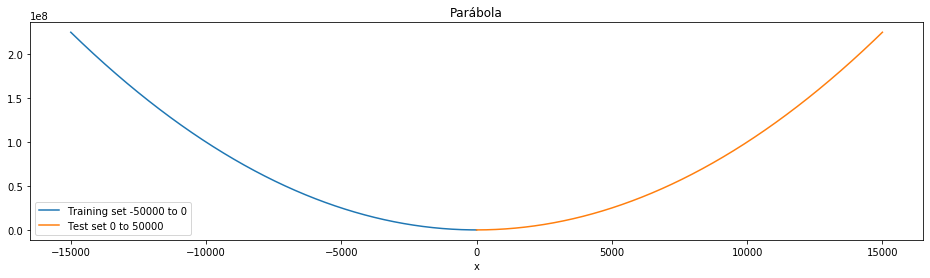

In [123]:
df["fx"].iloc[0:int(df.shape[0]*0.500)].plot(figsize=(16,4),legend=True)
df["fx"].iloc[int(df.shape[0]*0.500):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -50000 to 0',f'Test set 0 to 50000'])
plt.title('Parábola')
plt.show()

In [124]:
uni_data = df['fx']
uni_data.head()

x
-15000    225000000
-14999    224970001
-14998    224940004
-14997    224910009
-14996    224880016
Name: fx, dtype: int64

In [125]:
uni_data = uni_data.values

In [126]:
uni_train_mean = uni_data[:int(df.shape[0]*0.500)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.500)].std()

In [127]:
uni_train_mean

75007500.16666667

In [128]:
uni_train_std

67086231.77483961

Let's standardize the data.

In [129]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [130]:
univariate_past_history = 1800
univariate_future_target = 1800

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.500),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.500), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [164]:
0.008*1800

14.4

# Model testing

In [131]:
es = tf.keras.callbacks.EarlyStopping()

In [132]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish'))
multi_step_model.add(tf.keras.layers.Dense(1))

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [133]:
#multi_step_model = tf.keras.models.Sequential()

#multi_step_model.add(
#    tf.keras.layers.Embedding(input_dim=32,
             # input_length = 50,
             # output_dim=100,
             # trainable=False,
             #  mask_zero=True))

#multi_step_model.add(tf.keras.layers.LSTM(32,
#                                          return_sequences=True,
#                                          input_shape=x_train_uni.shape[-2:]))

#multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish',recurrent_activation='sigmoid'))

#multi_step_model.add(tf.keras.layers.Dropout(0.5))

#multi_step_model.add(tf.keras.layers.Dense(8))

# Masking layer for pre-trained embeddings
#multi_step_model.add(tf.keras.layers.Masking(mask_value=0.0))

#multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [134]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(500).batch(1000).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(1000).repeat()

Batch de 100 com shuffle de 50 não roda bem

In [135]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=5,
                                          steps_per_epoch=20,
                                          validation_data=val_data_multi,
                                          validation_steps=50,callbacks = [es])

Epoch 1/5
20/20 [==============================] - 141s 7s/step - loss: 0.4991 - val_loss: 0.6051
Epoch 2/5
20/20 [==============================] - 141s 7s/step - loss: 0.2127 - val_loss: 0.8198


In [139]:
i=0
prediction = pd.DataFrame()
for x,y in val_data_multi.take(12):
    print(i)
    df_sup = pd.DataFrame(((y *uni_train_std) + uni_train_mean))
    prediction = prediction.append(df_sup,ignore_index= True,)
    print(len(y))
    i+=1

0
1000
1
1000
2
1000
3
1000
4
1000
5
1000
6
1000
7
1000
8
1000
9
1000
10
1000
11
401


In [140]:
df

,fx
x,
-15000,225000000
-14999,224970001
-14998,224940004
-14997,224910009
-14996,224880016
...,...
14996,224880016
14997,224910009
14998,224940004


In [143]:
15000-11401

3599

In [ ]:
d

In [151]:
prediction.shape[0]

11401

In [155]:
prediction['new_index'] = list(range(3600,15001))

In [158]:
prediction = prediction.set_index('new_index')

In [161]:
prediction.rename(columns={0:'Prediction'},inplace = True)

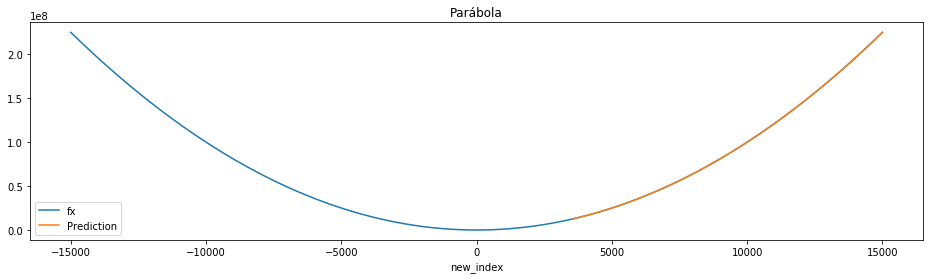

In [163]:
df['fx'].plot(figsize=(16,4),legend=True)
prediction['Prediction'].plot(figsize=(16,4),legend=True)
plt.title('Parábola')
plt.show()

#### Swish - sigmoid - 1100 x 375

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.741462553344384, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


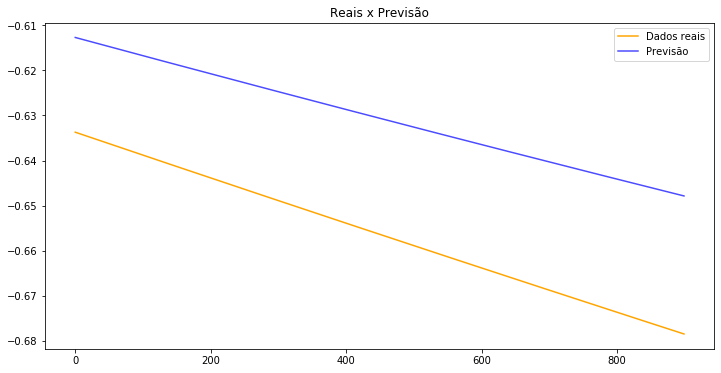

In [36]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

#### Swish - tanh

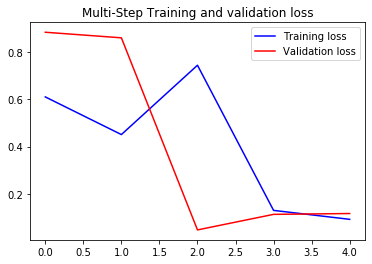

In [28]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7558181851012544, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


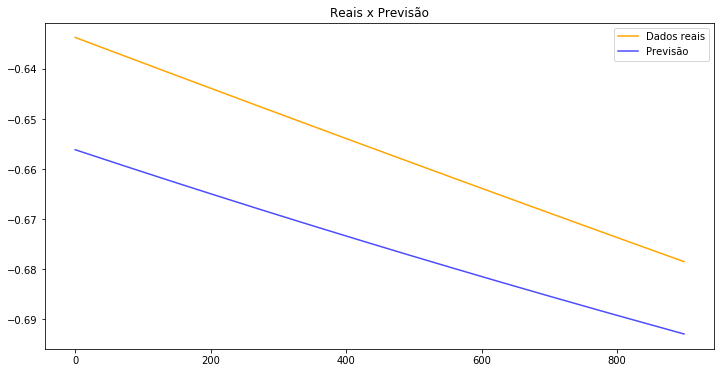

In [30]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

## Plottar O gráfico de -1000 a 1000
## Manter batchs maiores, próximos do nosso passado de treinamento

### Fazer um com tanh 
- testar com outros

#### Swish - TanH - 30 Steps
- Preciso diminuir o número de dados para enchergar melhor a curva do U

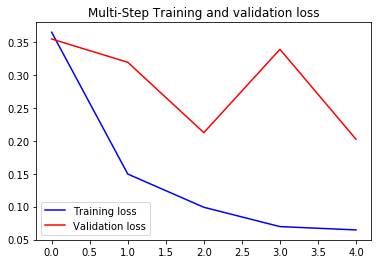

In [25]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.9265886089605513, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.9258632700306062, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=-0.09304769929493756, pvalue=7.701091905338401e-05)


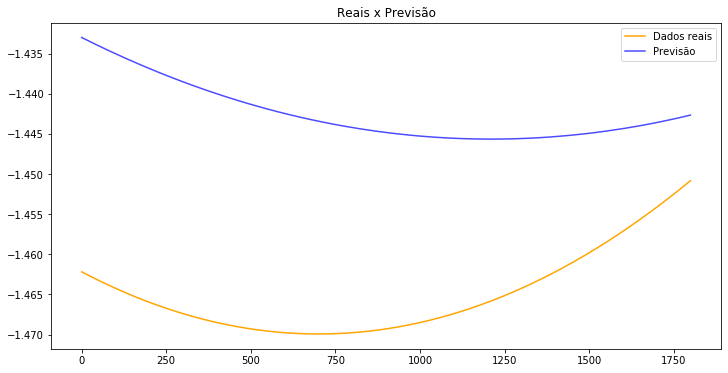

In [26]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

In [31]:
900/15000

0.06

In [61]:
0.480*30000

14400.0

#### Swish - TanH - 30 Steps
- Preciso diminuir o número de dados para enchergar melhor a curva do U

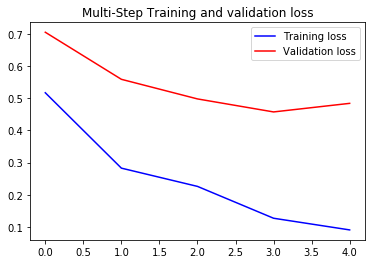

In [46]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [47]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

ValueError: operands could not be broadcast together with shapes (1000,) (1000,8) 